# Classification problems with Deep Learning

This notebook are my personal notes of the Datacamp course "Introduction to Deep Learning with Keras".

Outline:
1. [Binary classification](#Section-1.-Binary-classification)
1. [Multi-class classification](#Section-2.-Multi-class-classification)
1. [Multi-label classification](#Section-3.-Multi-label-classification)
1. [Using Keras callbacks](#Section-4.-Using-Keras-callbacks)

In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from config import datapaths

In [2]:
tf.__version__

'2.3.1'

## Section 1. Binary classification

We will practice building classification models in Keras with the Banknote Authentication dataset.

Our goal is to distinguish between real and fake dollar bills. In order to do this, the dataset comes with 4 features: variance, skewness, kurtosis and entropy. These features are calculated by applying mathematical operations over the dollar bill images. The labels are found in the dataframe's `class` column.

In [3]:
banknotes = pd.read_csv(datapaths['banknotes'])
banknotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variace   1372 non-null   float64
 1   skewness  1372 non-null   float64
 2   curtosis  1372 non-null   float64
 3   entropy   1372 non-null   float64
 4   class     1372 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.7 KB


In [4]:
banknotes.head(3)

,variace,skewness,curtosis,entropy,class
0,3.6216,8.6661,-2.8073,-0.44699,0
1,4.5459,8.1674,-2.4586,-1.46210,0
2,3.8660,-2.6383,1.9242,0.10645,0


In [5]:
banknotes['class'] = banknotes['class'].map({0: 'real', 1: 'fake'})

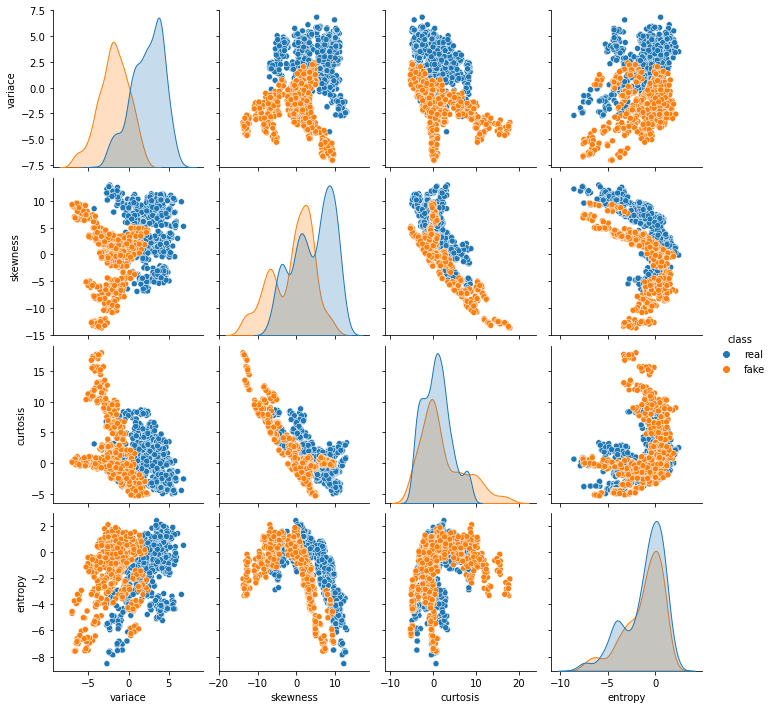

In [6]:
sns.pairplot(banknotes, hue='class')
plt.show()

This pairplot shows that there are features for which the classes spread out noticeably. This gives us an intuition about our classes being easily separable. Let's build a model to find out what it can do!

In [7]:
print('Observations per class: \n', banknotes['class'].value_counts())

Observations per class: 
 real    762
fake    610
Name: class, dtype: int64


### Building a binary classification NN model

In [8]:
banknotes['class'] = banknotes['class'].map({'real': 0, 'fake': 1})

In [9]:
X = banknotes.drop('class', axis=1).to_numpy()
y = banknotes['class'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(960, 4) (412, 4) (960,) (412,)


In [10]:
model = Sequential()
model.add(Dense(1, input_shape=(4,), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(X_train, y_train, epochs=20)
accuracy = model.evaluate(X_test, y_test)[1]
print('\nAccuracy:', accuracy)

Epoch 1/20
30/30 [==============================] - 0s 2ms/step - loss: 0.4889 - accuracy: 0.8188
Epoch 2/20
30/30 [==============================] - 0s 2ms/step - loss: 0.2979 - accuracy: 0.9052
Epoch 3/20
30/30 [==============================] - 0s 2ms/step - loss: 0.2619 - accuracy: 0.9125
Epoch 4/20
30/30 [==============================] - 0s 2ms/step - loss: 0.2372 - accuracy: 0.9177
Epoch 5/20
30/30 [==============================] - 0s 2ms/step - loss: 0.2185 - accuracy: 0.9260
Epoch 6/20
30/30 [==============================] - 0s 2ms/step - loss: 0.2035 - accuracy: 0.9302
Epoch 7/20
30/30 [==============================] - 0s 2ms/step - loss: 0.1911 - accuracy: 0.9365
Epoch 8/20
30/30 [==============================] - 0s 2ms/step - loss: 0.1807 - accuracy: 0.9417
Epoch 9/20
30/30 [==============================] - 0s 1ms/step - loss: 0.1720 - accuracy: 0.9406
Epoch 10/20
30/30 [==============================] - 0s 2ms/step - loss: 0.1644 - accuracy: 0.9479
Epoch 11/20
30/30 [

 It looks like you are getting a high accuracy even with this simple model!
 
 ## Section 2. Multi-class classification
 
We're going to build a model that predicts who threw which dart only based on where that dart landed! (That is the dart's x and y coordinates on the board.)

This problem is a multi-class classification problem since each dart can only be thrown by one of 4 competitors. So classes/labels are mutually exclusive, and therefore we can build a neuron with as many output as competitors and use the `softmax` activation function to achieve a total sum of probabilities of 1 over all competitors.


In [12]:
model = Sequential()

model.add(Dense(128, input_shape=(2,), activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [13]:
darts = pd.read_csv(datapaths['darts'])
darts.head(3)

,xCoord,yCoord,competitor
0,0.196451,-0.520341,Steve
1,0.476027,-0.306763,Susan
2,0.003175,-0.980736,Michael


In [14]:
darts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   xCoord      800 non-null    float64
 1   yCoord      800 non-null    float64
 2   competitor  800 non-null    object 
dtypes: float64(2), object(1)
memory usage: 18.9+ KB


`darts.competitor` are not yet in a format to be understood by our network. They contain the names of the competitors as strings. We will first turn these competitors into unique numbers, then use the `to_categorical()` function from `tf.keras.utils` to turn these numbers into their one-hot encoded representation.

In [15]:
darts.competitor

0        Steve
1        Susan
2      Michael
3         Kate
4        Steve
        ...   
795       Kate
796      Steve
797    Michael
798    Michael
799      Susan
Name: competitor, Length: 800, dtype: object

In [16]:
darts.competitor = pd.Categorical(darts.competitor)
darts.competitor

0        Steve
1        Susan
2      Michael
3         Kate
4        Steve
        ...   
795       Kate
796      Steve
797    Michael
798    Michael
799      Susan
Name: competitor, Length: 800, dtype: category
Categories (4, object): ['Kate', 'Michael', 'Steve', 'Susan']

In [17]:
darts.competitor = darts.competitor.cat.codes
print('Label encoded competitors:')
darts.competitor.head()

Label encoded competitors:


0    2
1    3
2    1
3    0
4    2
Name: competitor, dtype: int8

In [18]:
coordinates = darts.drop(['competitor'], axis=1)
competitors = to_categorical(darts.competitor)
print('One-hot encoded competitors:')
competitors

One-hot encoded competitors:


array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

 Each competitor is now a vector of length 4, full of zeroes except for the position representing her or himself.

In [19]:
packed_splits = train_test_split(coordinates, competitors, test_size=0.3, random_state=21)
coord_train, coord_test, competitors_train, competitors_test = packed_splits

In [20]:
history = model.fit(coord_train, competitors_train, epochs=200, verbose=0)
accuracy = model.evaluate(coord_test, competitors_test)[1]
print('Accuracy:', accuracy)

8/8 [==============================] - 0s 2ms/step - loss: 0.7178 - accuracy: 0.7875
Accuracy: 0.7875000238418579


In [43]:
darts_history = pd.DataFrame(history.history)
darts_history.head(3)

,loss,accuracy
0,1.372720,0.266071
1,1.328805,0.298214
2,1.273366,0.403571


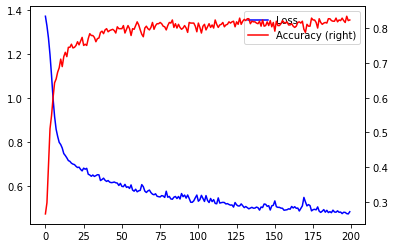

In [21]:
darts_history.loss.plot(c='b', label='Loss', legend=True)
darts_history.accuracy.plot(c='r', secondary_y=True, label='Accuracy', legend=True)
plt.show()

Our model just trained for 200 epochs. The accuracy on the test set is quite high. How are the predictions looking?

In [22]:
indices = np.random.randint(0, coord_test.shape[0], 5)

coords_small_test = np.take(coord_test.to_numpy(dtype=np.float32), indices, axis=0)
coords_small_test

array([[ 0.14874668, -0.4825459 ],
       [ 0.8330113 , -0.00621122],
       [ 0.21812835, -0.23352467],
       [-0.9656526 , -0.00933065],
       [-0.32920602,  0.3207321 ]], dtype=float32)

In [23]:
competitors_small_test = np.take(competitors_test, indices, axis=0)
competitors_small_test

array([[0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

### Softmax predictions

In [24]:
preds = model.predict(coords_small_test)

print("{:25} | {}".format('Raw Model Predictions', 'True labels'))
for i, pred in enumerate(preds):
    print("{} | {}".format(np.around(pred, 3), competitors_small_test[i]))

Raw Model Predictions     | True labels
[0.211 0.006 0.751 0.032] | [0. 0. 1. 0.]
[0.035 0.039 0.    0.926] | [0. 0. 0. 1.]
[0.381 0.012 0.575 0.031] | [0. 0. 1. 0.]
[0.    0.999 0.    0.001] | [0. 1. 0. 0.]
[0.934 0.004 0.024 0.037] | [1. 0. 0. 0.]


Extract the position of highest probability from each pred vector:

In [25]:
preds_chosen = [np.argmax(pred) for pred in preds]

print("{:10} | {}".format('Rounded Model Predictions', 'True labels'))
for i, pred in enumerate(preds_chosen):
    print("{:25} | {}".format(pred, competitors_small_test[i]))

Rounded Model Predictions | True labels
                        2 | [0. 0. 1. 0.]
                        3 | [0. 0. 0. 1.]
                        2 | [0. 0. 1. 0.]
                        1 | [0. 1. 0. 0.]
                        0 | [1. 0. 0. 0.]


As we've seen we can easily interpret the softmax output. This can also help us spot those observations where our network is less certain on which class to predict, since we can see the probability distribution among classes per prediction.

## Section 3. Multi-label classification

In [26]:
irrigation = pd.read_csv(datapaths['irrigation_machine'], index_col=0)
irrigation.head(3)

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,...,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,parcel_0,parcel_1,parcel_2
0,1.0,2.0,1.0,7.0,0.0,1.0,1.0,4.0,0.0,3.0,...,8.0,1.0,0.0,2.0,1.0,9.0,2.0,0,1,0
1,5.0,1.0,3.0,5.0,2.0,2.0,1.0,2.0,3.0,1.0,...,4.0,5.0,5.0,2.0,2.0,2.0,7.0,0,0,0
2,3.0,1.0,4.0,3.0,4.0,0.0,1.0,6.0,0.0,2.0,...,3.0,3.0,1.0,0.0,3.0,1.0,0.0,1,1,0


In [27]:
sensors = irrigation.filter(regex='sensor', axis=1)
sensors.head(3)

,sensor_0,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19
0,1.0,2.0,1.0,7.0,0.0,1.0,1.0,4.0,0.0,3.0,1.0,3.0,6.0,8.0,1.0,0.0,2.0,1.0,9.0,2.0
1,5.0,1.0,3.0,5.0,2.0,2.0,1.0,2.0,3.0,1.0,3.0,2.0,2.0,4.0,5.0,5.0,2.0,2.0,2.0,7.0
2,3.0,1.0,4.0,3.0,4.0,0.0,1.0,6.0,0.0,2.0,3.0,2.0,4.0,3.0,3.0,1.0,0.0,3.0,1.0,0.0


In [28]:
parcels = irrigation.filter(regex='parcel', axis=1)
parcels.head(3)

,parcel_0,parcel_1,parcel_2
0,0,1,0
1,0,0,0
2,1,1,0


In [29]:
packed_splits = train_test_split(sensors, parcels)
sensors_train, sensors_test, parcels_train, parcels_test = packed_splits

In [30]:
model = Sequential()

model.add(Dense(64, input_shape=(20,), activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 1,539
Trainable params: 1,539
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(sensors_train, parcels_train, epochs=100, validation_split=0.2, verbose=0)

preds = model.predict(sensors_test)
preds_rounded = np.round(preds)
print('Rounded Predictions:')
preds_rounded

accuracy = model.evaluate(sensors_test, parcels_test)[1]
print('Accuracy:', accuracy)

Rounded Predictions:
16/16 [==============================] - 0s 2ms/step - loss: 0.2333 - accuracy: 0.5600
Accuracy: 0.5600000023841858


We can see how the `validation_split` argument is useful for evaluating how your model performs as it trains.

## Section 4. Using Keras callbacks

In [39]:
def plot_loss(loss, val_loss):
    """Plot training & validation loss values"""
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

In [40]:
def plot_accuracy(acc,val_acc):
    """Plot training & validation accuracy values"""
    plt.figure()
    plt.plot(acc)
    plt.plot(val_acc)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='best')
    plt.show()

In [49]:
model = Sequential()

model.add(Dense(64, input_shape=(20,), activation='relu'))
model.add(Dense(3, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

h_callback = model.fit(sensors_train, parcels_train, epochs=50, validation_data=(sensors_test, parcels_test), verbose=0)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 64)                1344      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 195       
Total params: 1,539
Trainable params: 1,539
Non-trainable params: 0
_________________________________________________________________
None


In [46]:
h_callback

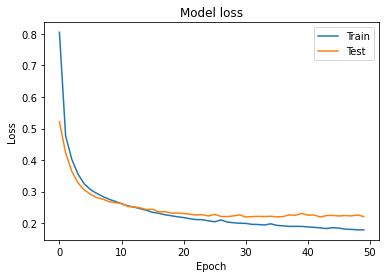

In [47]:
plot_loss(h_callback.history['loss'], h_callback.history['val_loss'])

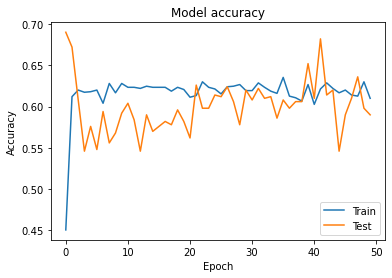

In [48]:
plot_accuracy(h_callback.history['accuracy'], h_callback.history['val_accuracy'])

These graphs are really useful for detecting overfitting and to know if your neural network would benefit from more training data.

### Early stopping and model checkpoint on the banknotes dataset

In [71]:
model = Sequential()
model.add(Dense(1, input_shape=(4,), activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [72]:
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=100)
model_checkpoint = ModelCheckpoint('out/best_banknote_model.hdf5', save_best_only=True)

In [73]:
r = model.fit(X_train, y_train, epochs=1_000_000_000_000,
              validation_data=(X_test, y_test), 
              callbacks=[monitor_val_acc, model_checkpoint])

Epoch 1/1000000000000
30/30 [==============================] - 0s 5ms/step - loss: 0.4093 - accuracy: 0.8333 - val_loss: 0.3311 - val_accuracy: 0.8641
Epoch 2/1000000000000
30/30 [==============================] - 0s 3ms/step - loss: 0.2958 - accuracy: 0.8729 - val_loss: 0.2566 - val_accuracy: 0.8908
Epoch 3/1000000000000
30/30 [==============================] - 0s 2ms/step - loss: 0.2448 - accuracy: 0.8990 - val_loss: 0.2214 - val_accuracy: 0.9150
Epoch 4/1000000000000
30/30 [==============================] - 0s 2ms/step - loss: 0.2185 - accuracy: 0.9198 - val_loss: 0.2010 - val_accuracy: 0.9320
Epoch 5/1000000000000
30/30 [==============================] - 0s 3ms/step - loss: 0.2018 - accuracy: 0.9260 - val_loss: 0.1871 - val_accuracy: 0.9369
Epoch 6/1000000000000
30/30 [==============================] - 0s 2ms/step - loss: 0.1896 - accuracy: 0.9292 - val_loss: 0.1765 - val_accuracy: 0.9369
Epoch 7/1000000000000
30/30 [==============================] - 0s 2ms/step - loss: 0.1798 - ac

Epoch 55/1000000000000
30/30 [==============================] - 0s 3ms/step - loss: 0.0799 - accuracy: 0.9792 - val_loss: 0.0766 - val_accuracy: 0.9782
Epoch 56/1000000000000
30/30 [==============================] - 0s 3ms/step - loss: 0.0793 - accuracy: 0.9792 - val_loss: 0.0760 - val_accuracy: 0.9782
Epoch 57/1000000000000
30/30 [==============================] - 0s 2ms/step - loss: 0.0787 - accuracy: 0.9792 - val_loss: 0.0754 - val_accuracy: 0.9782
Epoch 58/1000000000000
30/30 [==============================] - 0s 3ms/step - loss: 0.0781 - accuracy: 0.9792 - val_loss: 0.0748 - val_accuracy: 0.9782
Epoch 59/1000000000000
30/30 [==============================] - 0s 2ms/step - loss: 0.0775 - accuracy: 0.9792 - val_loss: 0.0742 - val_accuracy: 0.9782
Epoch 60/1000000000000
30/30 [==============================] - 0s 2ms/step - loss: 0.0770 - accuracy: 0.9802 - val_loss: 0.0737 - val_accuracy: 0.9806
Epoch 61/1000000000000
30/30 [==============================] - 0s 3ms/step - loss: 0.07

Epoch 109/1000000000000
30/30 [==============================] - 0s 4ms/step - loss: 0.0587 - accuracy: 0.9854 - val_loss: 0.0561 - val_accuracy: 0.9879
Epoch 110/1000000000000
30/30 [==============================] - 0s 4ms/step - loss: 0.0585 - accuracy: 0.9854 - val_loss: 0.0558 - val_accuracy: 0.9879
Epoch 111/1000000000000
30/30 [==============================] - 0s 4ms/step - loss: 0.0582 - accuracy: 0.9854 - val_loss: 0.0556 - val_accuracy: 0.9879
Epoch 112/1000000000000
30/30 [==============================] - 0s 4ms/step - loss: 0.0580 - accuracy: 0.9854 - val_loss: 0.0554 - val_accuracy: 0.9879
Epoch 113/1000000000000
30/30 [==============================] - 0s 4ms/step - loss: 0.0578 - accuracy: 0.9854 - val_loss: 0.0551 - val_accuracy: 0.9879
Epoch 114/1000000000000
30/30 [==============================] - 0s 4ms/step - loss: 0.0576 - accuracy: 0.9854 - val_loss: 0.0549 - val_accuracy: 0.9879
Epoch 115/1000000000000
30/30 [==============================] - 0s 4ms/step - los

30/30 [==============================] - 0s 4ms/step - loss: 0.0492 - accuracy: 0.9875 - val_loss: 0.0469 - val_accuracy: 0.9879
Epoch 163/1000000000000
30/30 [==============================] - 0s 4ms/step - loss: 0.0491 - accuracy: 0.9875 - val_loss: 0.0468 - val_accuracy: 0.9879
Epoch 164/1000000000000
30/30 [==============================] - 0s 4ms/step - loss: 0.0490 - accuracy: 0.9885 - val_loss: 0.0467 - val_accuracy: 0.9879
Epoch 165/1000000000000
30/30 [==============================] - 0s 4ms/step - loss: 0.0489 - accuracy: 0.9885 - val_loss: 0.0465 - val_accuracy: 0.9879
Epoch 166/1000000000000
30/30 [==============================] - 0s 4ms/step - loss: 0.0487 - accuracy: 0.9875 - val_loss: 0.0464 - val_accuracy: 0.9879
Epoch 167/1000000000000
30/30 [==============================] - 0s 4ms/step - loss: 0.0486 - accuracy: 0.9885 - val_loss: 0.0463 - val_accuracy: 0.9879
Epoch 168/1000000000000
30/30 [==============================] - 0s 4ms/step - loss: 0.0485 - accuracy: 0.

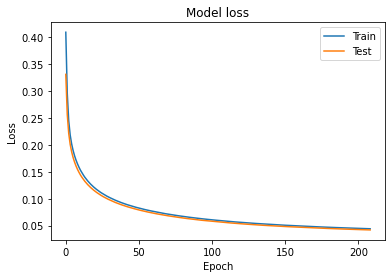

In [74]:
plot_loss(r.history['loss'], r.history['val_loss'])

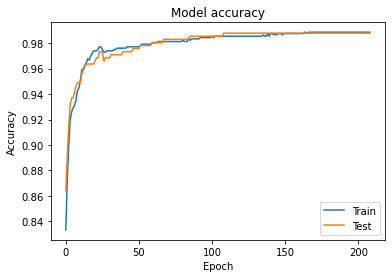

In [75]:
plot_accuracy(r.history['accuracy'], r.history['val_accuracy'])